In [62]:
#!/usr/bin/python
#-*- coding: utf-8 -*-

# >.>.>.>.>.>.>.>.>.>.>.>.>.>.>.>.
# Licensed under the Apache License, Version 2.0 (the "License")
# You may obtain a copy of the License at
# http://www.apache.org/licenses/LICENSE-2.0

# --- File Name: show_travs
# --- Author: Xinqi Zhu
# .<.<.<.<.<.<.<.<.<.<.<.<.<.<.<.<
"""
Show traversals for nav models.
"""
%matplotlib inline

import os

from typing import List
import pickle
import click
import matplotlib.pyplot as plt
import dnnlib
import numpy as np
import torch
import torch.nn.functional as F
import cv2
import IPython
from PIL import Image as ImagePIL
from IPython.display import Image, display

from training.w_walk_utils import get_w_walk, get_w_walk_SVD_step

import legacy

In [63]:
generator_pkl = 'ffhq512'
# pcaatt_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_pca_table1_ffhq512_1/00000-ffhq512-z_10-lr_0.05-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_pca-neig_100-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_1-kimg600-batch10/network-snapshot-000600.pkl'
pcaatt_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_bi_pca_ffhq512/00003-ffhq512-z_30-lr_0.05-vars_1-wals_0.3-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_pca-neig_4-afc_3-nfc_3-atl_16-atg_3-cont_1-pos_1-neg_1-div_0.1-ncol_2-dys_T-kimg300-batch12/network-snapshot-000300.pkl'
pca_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_pcabase_ffhq512/00002-ffhq512-z_50-lr_0.01-wals_1-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_none-nt_pca-neig_100-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0-ncol_2-dys_T-vars_0.5-kimg80-batch6/network-snapshot-init.pkl'
truncation_psi = 0.5
outdir = '/mnt/hpc_scratch/stylegan2-ada-pytorch/show_evolution'

In [64]:
os.makedirs(outdir, exist_ok=True)

In [65]:
print('Loading generator networks from "%s"...' % generator_pkl)

resume_specs = {
    'ffhq256':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl',
    'ffhq512':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl',
    'ffhq1024':    'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res1024-mirror-stylegan2-noaug.pkl',
    'celebahq256': 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/celebahq-res256-mirror-paper256-kimg100000-ada-target0.5.pkl',
    'lsundog256':  'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/lsundog-res256-paper256-kimg100000-noaug.pkl',
}

assert generator_pkl is not None
if generator_pkl in resume_specs:
    generator_pkl = resume_specs[generator_pkl] # predefined url

device = torch.device('cuda:0')
# device = torch.device('cpu')
with dnnlib.util.open_url(generator_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].requires_grad_(False).to(device) # type: ignore

with open(pcaatt_pkl, 'rb') as f:
    resume_data = pickle.load(f)
    M = resume_data['M'].requires_grad_(False).to(device)
    
with open(pca_pkl, 'rb') as f:
    resume_data = pickle.load(f)
    M_2 = resume_data['M'].requires_grad_(False).to(device)
print('Done loading')

Loading generator networks from "ffhq512"...
Done loading


In [66]:
plt.rcParams['figure.figsize'] = [18, 18]

def imshow(img, surfix='0'):
    img = np.rint(img * 255).clip(0, 255).astype(np.uint8)
    img = ImagePIL.fromarray(np.transpose(img, (1,2,0)))
    img.save(os.path.join(outdir, f'tmp_{surfix}.jpg'))
    display(Image(filename=os.path.join(outdir, f'tmp_{surfix}.jpg')))

def show(img, im_range=[-1,1], **kwargs):
    img = (img - im_range[0]) / (im_range[1] - im_range[0])
    npimg = img.cpu().numpy()
    imshow(npimg, **kwargs)
    # plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

grid: (3, 30)
torch.Size([18, 3, 512, 512])


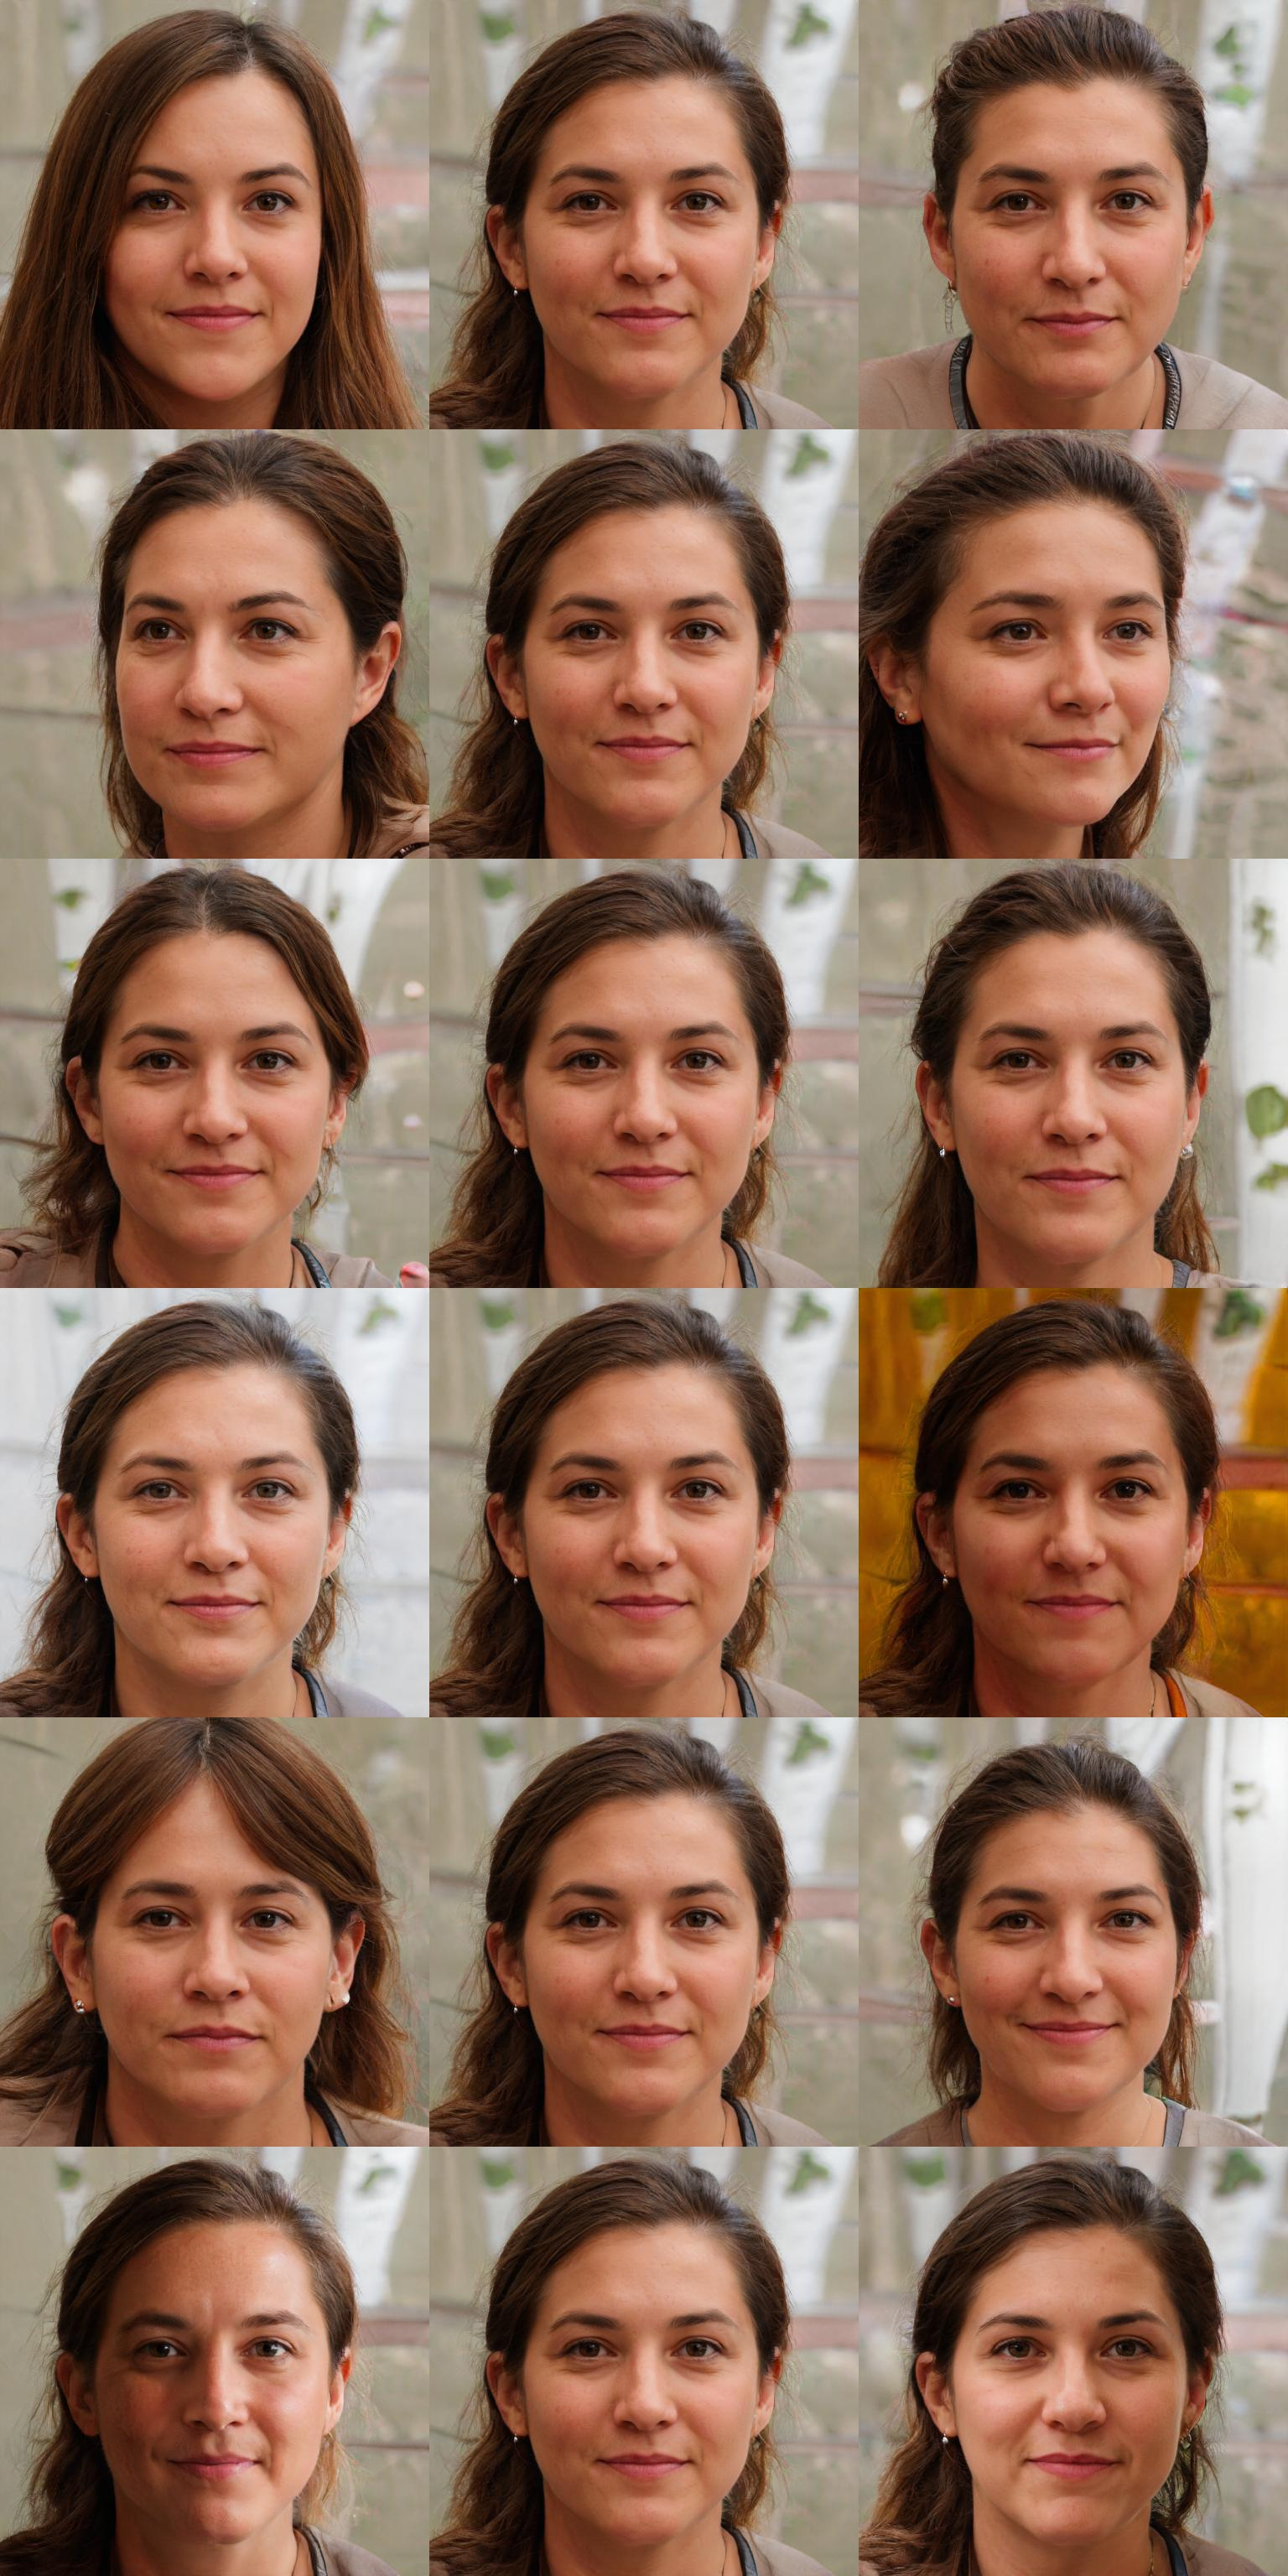

In [93]:
batch_size = 4
n_samples_per = 3
step_scales = [0.6, 0.8, 0.5, 1.2, 1, 0.4]
seed = 401 # 307
torch.random.manual_seed(seed)
walk_grid_size = (n_samples_per, M.nv_dim) # (gw, gh)
print('grid:', walk_grid_size)

z_origin = torch.randn([1, G.z_dim], device=device)
c_origin = torch.randn([1, G.c_dim], device=device)
w_origin = G.mapping(z_origin, c_origin, truncation_psi=truncation_psi) # (1, num_ws, w_dim)
dirs_orig = M(w_origin) # [1, n_lat, num_ws, w_dim]
_, n_lat, num_ws, w_dim = dirs_orig.shape
#w_origin = w_origin.repeat(n_lat, 1, 1)

# show_dims = min(M.nv_dim, len(step_scales))
show_dims = [0, 1, 5, 8, 9, 15]
steps = []
dirs = M(w_origin)
for i in range(len(show_dims)):
    delta = dirs[:, show_dims[i]] # [1, num_ws, w_dim]
    step = w_origin.clone()
    steps_per_dim = [step]
    for _ in range(n_samples_per // 2):
        step = step - step_scales[i] * delta # [1, num_ws, w_dim]
        steps_per_dim = [step] + steps_per_dim
    step = w_origin.clone()
    for _ in range(n_samples_per - 1 - n_samples_per // 2):
        step = step + step_scales[i] * delta # [1, num_ws, w_dim]
        steps_per_dim = steps_per_dim + [step]
    steps = steps + steps_per_dim
steps_tensor = torch.cat(steps, dim=0) # [nv_dim * n_samples_per, nums_ws, w_dim]
w_walk = steps_tensor.split(batch_size)
images = torch.cat([G.synthesis(w, noise_mode='const') for w in w_walk]) # (nv_dim * n_samples_per, c, h, w)
_, c, h, w = images.shape
print(images.shape)
images = images.view(len(show_dims), n_samples_per, c, h, w).permute((2, 0, 3, 1, 4)).reshape(
    c, len(show_dims)*h, n_samples_per*w)
show(images, surfix=str(seed)+"_model")


torch.Size([18, 3, 512, 512])


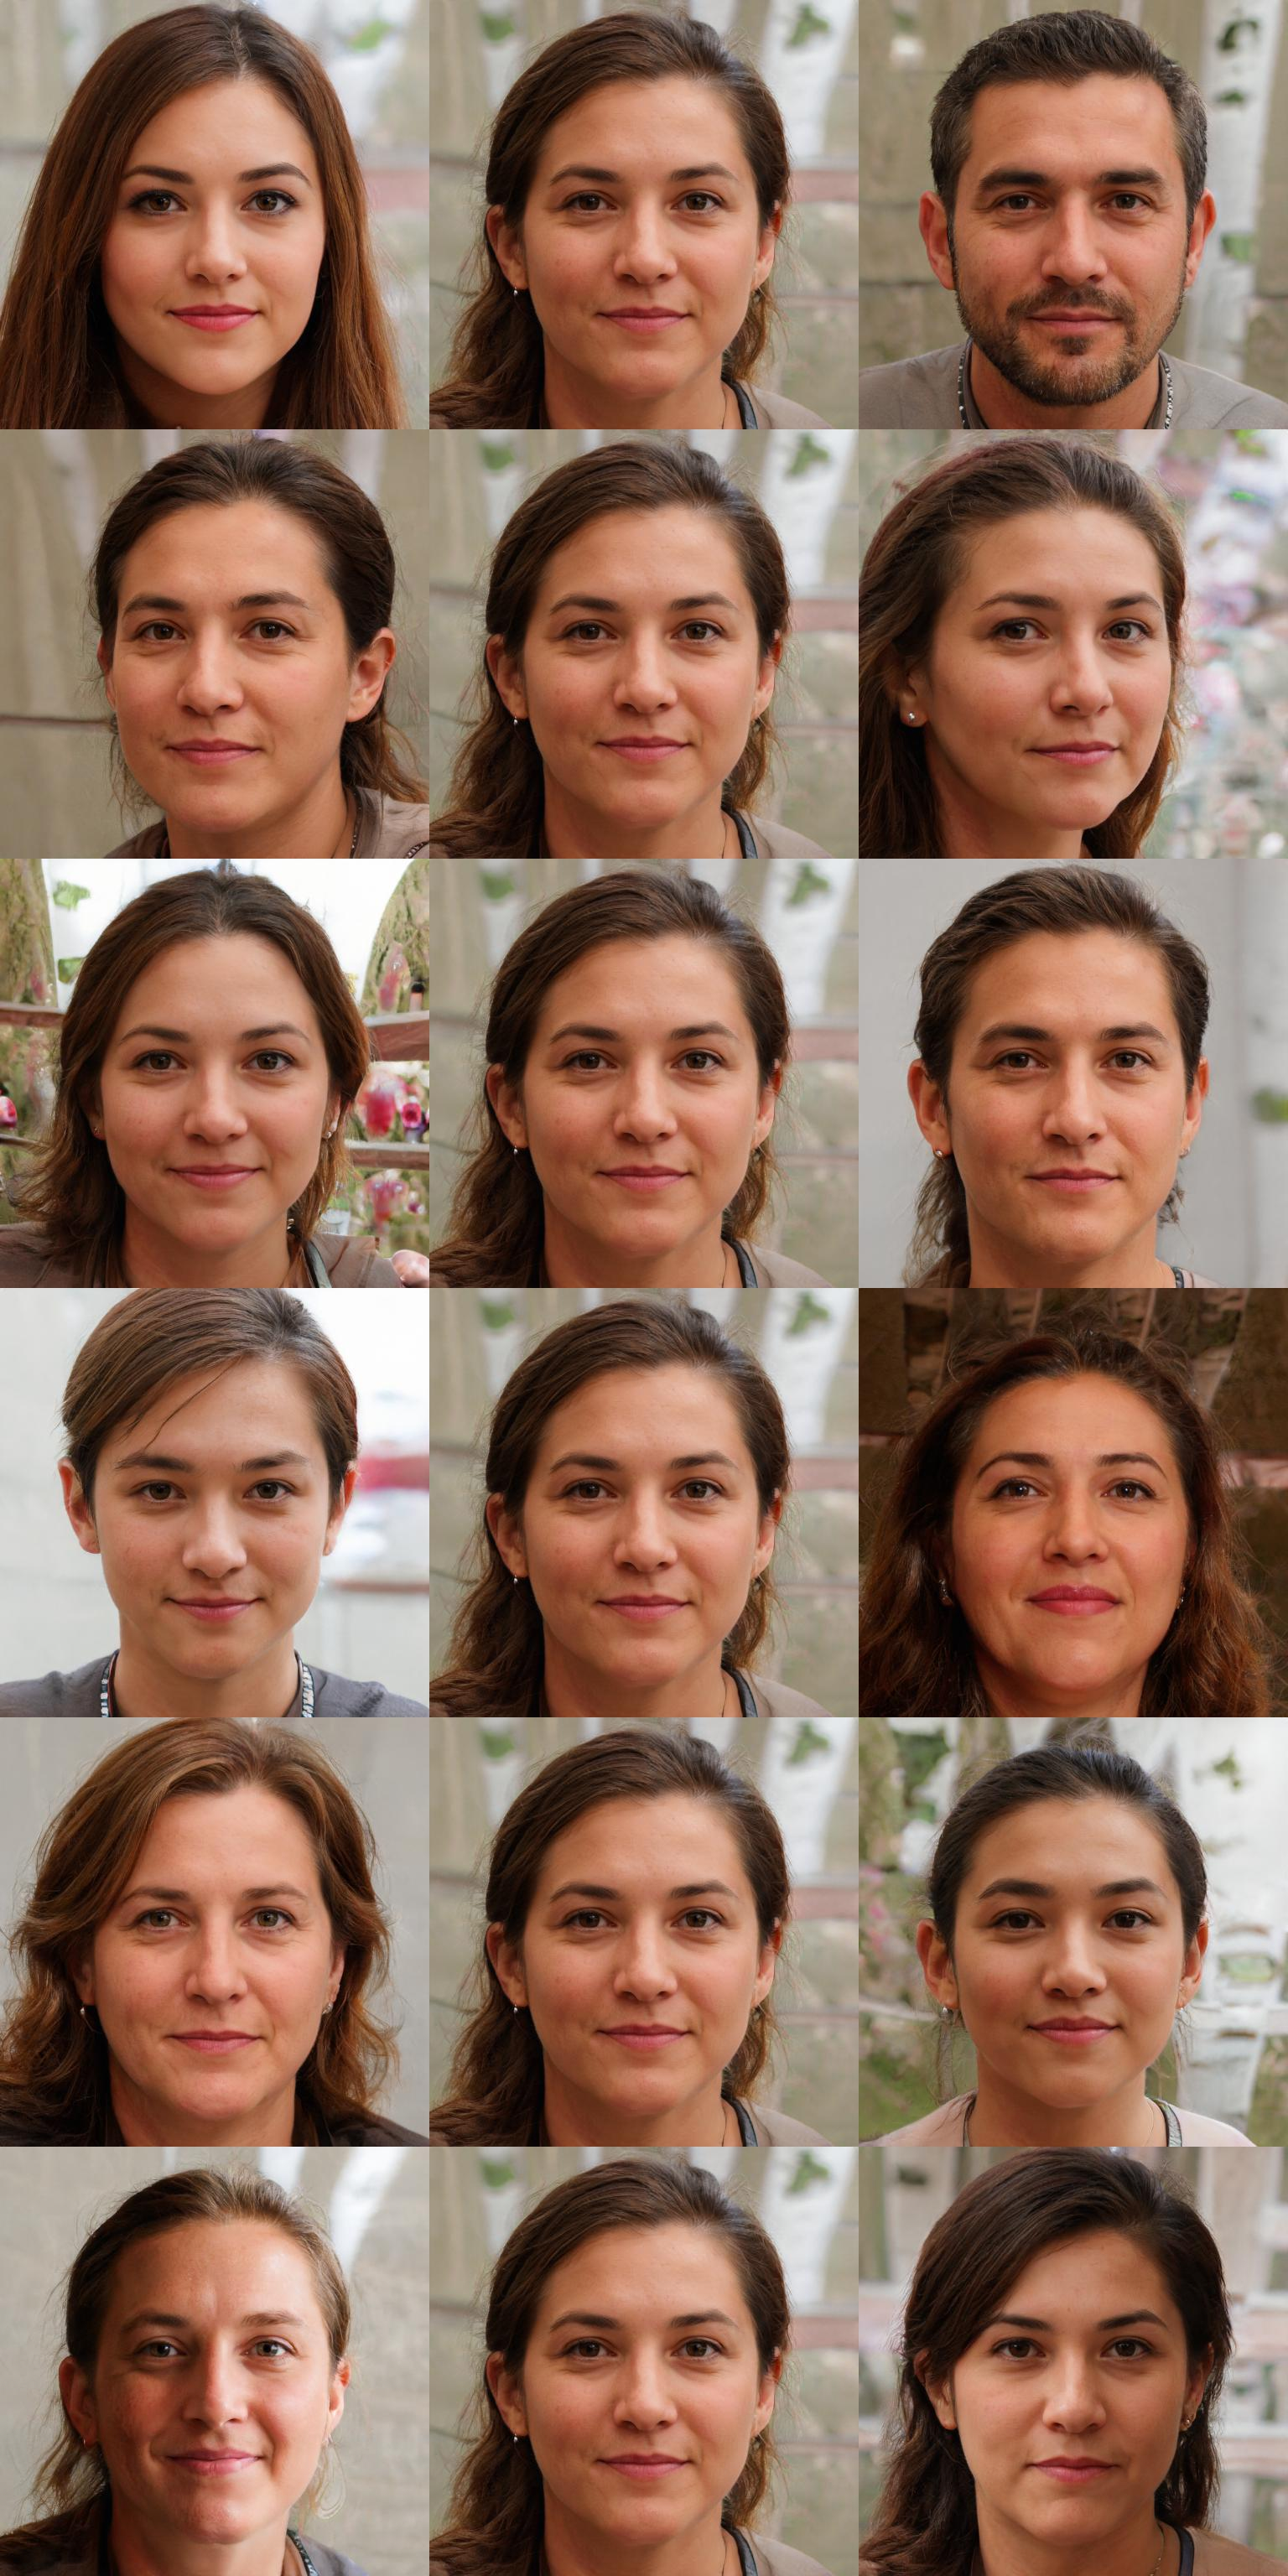

In [94]:
steps = []
dirs = M_2(w_origin)
step_scales = [2.3, 2.7, 2.7, 3, 2.2, 2.2]
# show_nv_dim = min(M.nv_dim, len(step_scales))
for i in range(len(show_dims)):
    delta = dirs[:, show_dims[i]] # [1, num_ws, w_dim]
    step = w_origin.clone()
    steps_per_dim = [step]
    for _ in range(n_samples_per // 2):
        step = step - step_scales[i] * delta # [1, num_ws, w_dim]
        steps_per_dim = [step] + steps_per_dim
    step = w_origin.clone()
    for _ in range(n_samples_per - 1 - n_samples_per // 2):
        step = step + step_scales[i] * delta # [1, num_ws, w_dim]
        steps_per_dim = steps_per_dim + [step]
    steps = steps + steps_per_dim
steps_tensor = torch.cat(steps, dim=0) # [nv_dim * n_samples_per, nums_ws, w_dim]
w_walk = steps_tensor.split(batch_size)
images = torch.cat([G.synthesis(w, noise_mode='const') for w in w_walk]) # (nv_dim * n_samples_per, c, h, w)
_, c, h, w = images.shape
print(images.shape)
images = images.view(len(show_dims), n_samples_per, c, h, w).permute((2, 0, 3, 1, 4)).reshape(
    c, len(show_dims)*h, n_samples_per*w)
show(images, surfix=str(seed)+'_pca')